# Deep Deterministic Policy Gradients (DDPG)
---
In this notebook, we train DDPG with OpenAI Gym's BipedalWalker-v2 environment.

### 1. Import the Necessary Packages

In [2]:
!pip install gymnasium[box2d]
import gymnasium as gym
import random
import torch
import numpy as np
#from google.colab import files
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

from ddpg_agent_bip_X import Agent

In [ ]:
!nvcc --version

### 2. Instantiate the Environment and Agent

In [ ]:
#gymnasium/envs/box2d/bipedal_walker.py
#gym.pprint_registry()
#gym.spec("BipedalWalker-v3")

In [14]:
from ddpg_agent_bip_X import Agent

env = gym.make('BipedalWalker-v3', render_mode="rgb_array")
seed=10
state_size=env.observation_space.shape[0]
action_size=env.action_space.shape[0]
agent = Agent(state_size=state_size, action_size=action_size, random_seed=seed)
print(state_size, action_size)

agent.actor_local.load_state_dict(torch.load('highscore_actor_bip.pth'))#, map_location=torch.device('cpu')))
agent.critic_local.load_state_dict(torch.load('highscore_critic_bip.pth'))#, map_location=torch.device('cpu')))

24 4


<All keys matched successfully>

In [ ]:
#from ddpg_agent_pend import Agent

env = gym.make('Pendulum-v1', render_mode="rgb_array")
seed=10
state_size=env.observation_space.shape[0]
action_size=env.action_space.shape[0]
agent = Agent(state_size=state_size, action_size=action_size, random_seed=seed)
print(state_size, action_size)

### 3. Train the Agent with DDPG

Run the code cell below to train the agent from scratch.  Alternatively, you can skip to the next code cell to load the pre-trained weights from file.

In [15]:
def ddpg(n_episodes=2000, max_t=1600, max_score=-10000.):
    scores_deque = deque(maxlen=100)
    scores = []
    #max_score = -10000 #-np.Inf
    for i_episode in range(1, n_episodes+1):
        state, _ = env.reset(seed=seed)
        agent.reset()
        score = 0
        for step in range(max_t):
            action = agent.act(state)
            next_state, reward, done, trun, _ = env.step(action)
            agent.step(step, state, action, reward, next_state, done or trun)
            state = next_state
            score += reward
            if done or trun:
                break 
        scores_deque.append(score)
        scores.append(score)
        if score >= max_score + int(np.round(np.abs(0.2*max_score))):
            torch.save(agent.actor_local.state_dict(), './data/highscore_actor_bip.pth')
            torch.save(agent.critic_local.state_dict(), './data/highscore_critic_bip.pth')
            print('\rEpisode {}\tNEW HIGH SCORE! {:.2f}'.format(i_episode,score))
            max_score = score           
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score), end="")
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), './data/checkpoint_actor_bip.pth')
            torch.save(agent.critic_local.state_dict(), './data/checkpoint_critic_bip.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}\tHigh Score: {:.2f}'.format(i_episode, np.mean(scores_deque), max_score))   
    return scores, max_score


In [ ]:
n_episodes=[1000, 500,  500,  500, 500, 1000, 1000]
max_t=     [50,   100,  200,  400,  50, 350,  700]
n_episodes=[ne//2 for ne in n_episodes]

#n_episodes=[300, 600, 300, 600, 300,  600,  1200, 600, 300]
#max_t=     [50,  150, 300, 600, 1200, 2400, 3600, 600, 150]

In [ ]:
#scores = ddpg(n_episodes=2000, max_t=800)
# ~23 min for N=1000 T=500
scores = []; new_scores = []; high_score = -10000.
n_episodes=[200, 600]#, 300, 300, 600,  300, 300, 600]
max_t=     [1200, 1000]#, 200, 600, 1200, 200, 400, 800]
n_episodes=[ne//2 for ne in n_episodes]

for ne, mt in zip(n_episodes, max_t):
    print('\r### Episodes: {}\tTime Limit: {:.2f} ###'.format(ne,mt))
    new_scores, high_score = ddpg(n_episodes=ne, max_score=high_score)
    scores += new_scores


In [6]:
torch.save(agent.actor_local.state_dict(), './data/checkpoint_actor_bip.pth')
torch.save(agent.critic_local.state_dict(), './data/checkpoint_critic_bip.pth')
#files.download('checkpoint_criticA_bip.pth')
#files.download('checkpoint_actorA_bip.pth')

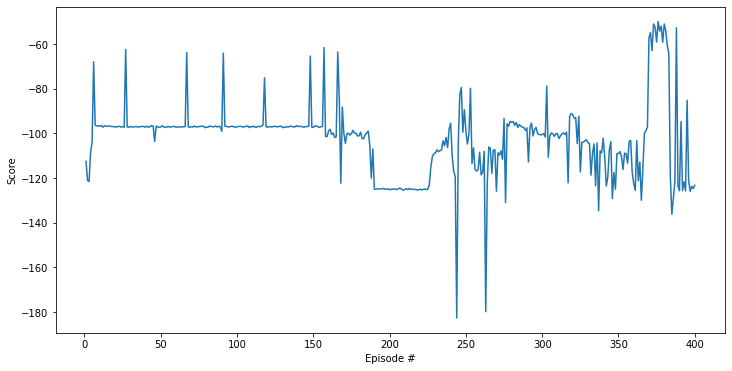

In [7]:
### Scores plot
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [ ]:
agent.actor_local.load_state_dict(torch.load('./data/highscore_actorA_bip.pth'))
agent.critic_local.load_state_dict(torch.load('./data/highscore_criticA_bip.pth'))

<All keys matched successfully>

Total episode reward:  -38.13


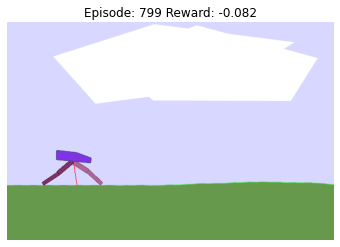

In [12]:
#### Display from DQN notebook
rewards = []
steps = []
t = 800 #1600
state, info = env.reset(seed=seed)
img = plt.imshow(env.render())
for j in range(t):
    action = agent.act(state)
    state, reward, done, trun, info = env.step(action)
    #print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(j, np.mean(rewards), reward), end="")
    rewards += [reward]
    img.set_data(env.render()) 
    plt.axis('off')
    plt.title("Episode: "+str(j)+" Reward: "+str(np.round(reward,3)))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    if done or trun:
        break 
print("Total episode reward: ", np.round(np.sum(rewards),3))

In [ ]:
action

array([-0.39315894,  1.        ,  1.        , -0.4698892 ], dtype=float32)

In [ ]:
#### Get data
rewards = []
final_rewards = []
steps = []
actions = []
tries = 100
max_t = 400
for i in range(tries):
    step_count = 0
    reward_sum = 0
    state, info = env.reset(seed=seed)
    for j in range(max_t):
        action = agent.act(state)
        actions += [action]
        state, reward, done, trun, info = env.step(action)
        if done or trun:
            final_rewards += [reward]
            break 
        else:
            final_rewards += [0]
            reward_sum += reward
            step_count += 1
    steps += [step_count]
    rewards += [reward_sum]
actions = np.asarray(actions)
data = np.asarray([(int(s),int(r),int(f)) for s,r,f in zip(steps, np.round(rewards), final_rewards)])

In [ ]:
#data = np.asarray([(int(s),int(r),int(f)) for s,r,f in zip(steps, np.round(rewards), final_rewards)])
[d for d in data if d[1]<0 ]

[array([288,  -6,   0]),
 array([400,  -3,   0]),
 array([175,  -3,   0]),
 array([146, -10,   0]),
 array([400,  -2,   0]),
 array([196,  -3,   0]),
 array([400,  -3,   0]),
 array([279,  -3,   0]),
 array([400,  -9,   0]),
 array([151,  -4,   0]),
 array([400,  -5,   0]),
 array([400,  -4,   0]),
 array([400,  -5,   0]),
 array([400,  -2,   0])]

In [ ]:
actions[-10:]

array([[-0.32351214,  1.        ,  1.        , -0.33578947],
       [-0.24482307,  1.        ,  1.        , -0.4056626 ],
       [-0.29525715,  1.        ,  1.        , -0.38740957],
       [-0.30665335,  1.        ,  1.        , -0.4045489 ],
       [-0.30210614,  1.        ,  1.        , -0.37225235],
       [-0.32172832,  1.        ,  1.        , -0.42449   ],
       [-0.24334897,  1.        ,  1.        , -0.37476447],
       [-0.35253546,  1.        ,  1.        , -0.28866184],
       [-0.28378263,  1.        ,  1.        , -0.3329869 ],
       [-0.2082048 ,  1.        ,  1.        , -0.23672721]],
      dtype=float32)

In [ ]:
np.mean(data[:,1]/data[:,0])

-0.2359221411435386

In [ ]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), rewards)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()
print("Total Rewards[:-1]", sum(rewards), "Average Reward:", np.mean(rewards))

In [ ]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards[:-1])+1), rewards[:-1])
plt.ylabel('Score')
plt.xlabel('Step #')
plt.show()
print("Total Rewards[:-1]", sum(rewards[:-1]), "Final Reward:", rewards[-1])

# 5. Explore

In this exercise, we have provided a sample DDPG agent and demonstrated how to use it to solve an OpenAI Gym environment.  To continue your learning, you are encouraged to complete any (or all!) of the following tasks:
- **Amend the various hyperparameters and network architecture to see if you can get your agent to solve the environment faster than this benchmark implementation.**  Once you build intuition for the hyperparameters that work well with this environment, try solving a different OpenAI Gym task!
- Write your own DDPG implementation.  Use this code as reference only when needed -- try as much as you can to write your own algorithm from scratch.
- You may also like to implement **prioritized experience replay**, to see if it speeds learning.  
- The current implementation adds Ornsetein-Uhlenbeck noise to the action space.  However, it has [been shown](https://blog.openai.com/better-exploration-with-parameter-noise/) that **adding noise to the parameters of the neural network policy can improve performance.  Make this change to the code, to verify it for yourself!**
- Write a blog post explaining the intuition behind the DDPG algorithm and demonstrating how to use it to solve an RL environment of your choosing.  

## How well does DQN with Tile Coding how well does work?
* Reuse DQN from Project 1, but use Tile Coding to turn continuous into discrete actions
* Implement improvements on DQN from Project 1 first